# DL based Onsets & Offsets Transcription of Piano
___
by WYQY

# 1. Initialization

In [1]:
# import modules
import os
import time
import random
import importlib
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
# setup magic function
%load_ext tensorboard
%matplotlib auto
# %config InlineBackend.figure_format = 'svg'

Using matplotlib backend: Qt5Agg


In [2]:
# import projects
import src.component.initial as initial
import src.component.util as util
import src.component.pre_spec_transform as spec_transform
import src.component.pre_sheet_transform as sheet_transform
import src.component.model_preprocessing as model_preprocessing
# import CNN models
import src.component.model_cnn_common as model_cnn_common
import src.component.model_cnn_build as model_cnn_build
import src.component.model_cnn_train as model_cnn_train
import src.component.model_cnn_inference as model_cnn_inference
import src.component.model_cnn_eval as model_cnn_eval
# import RNN models

In [3]:
# test
# 输出Tensorflow版本信息, 检查GPU
# 在Tensorflow2.4.0 (GPU@CUDA11.0@cuDNN8.0.4) Tensroflow_Addons0.12.1版本上检查通过
# 若GPU无法找到, 请至配置文件中自定义xfa路径并重新初始化
print(tf.__version__)
print(tf.keras.__version__)
print(tfa.__version__)
print('GPU', tf.config.list_physical_devices('GPU'))

2.4.1
2.4.0
0.12.1
GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# (备用) 重载入模块
# base
importlib.reload(initial)
importlib.reload(util)
importlib.reload(spec_transform)
importlib.reload(sheet_transform)
importlib.reload(model_preprocessing)
# CNN model
importlib.reload(model_cnn_common)
importlib.reload(model_cnn_build)
importlib.reload(model_cnn_train)
importlib.reload(model_cnn_inference)
# RNN model

<module 'src.component.model_cnn_inference' from 'd:\\Model\\WYQY_Model\\src\\component\\model_cnn_inference.py'>

# 2. Data Initialization & Spectrum Test

## 2.1) Data Initialization

In [4]:
# (可选) 预处理频谱数据删除
model_preprocessing.delete_spec_preprocess()

trainsets percentage: 100.0 [210/210]
testests percentage: 100.0 [60/60]


In [4]:
# (可选) 预处理曲谱数据删除
model_preprocessing.delete_sheet_preprocess()

trainsets percentage: 100.0 [210/210]
testests percentage: 100.0 [60/60]


In [12]:
# 频谱数据预处理
model_preprocessing.spec_preprocess()

trainsets percentage: 100.0 [210/210]
testests percentage: 100.0 [60/60]


In [5]:
# 曲谱数据预处理
model_preprocessing.sheet_preprocess()

trainsets percentage: 100.0 [210/210]
testests percentage: 100.0 [60/60]


## 2.2) Spectrogram & PianoRoll Test

### logMel Spectrum
___

In [5]:
# 测试指定位置的wav文件logMel频谱, 并画图
spec_logmel = spec_transform.rs_spec_logMel(sr=initial.config['spec.logmel.sampling'],
                                            lower_edge_hertz=initial.config['spec.logmel.lower.edge'],
                                            upper_edge_hertz=initial.config['spec.logmel.upper.edge'],
                                            hop_length=initial.config['spec.logmel.hop_length'],
                                            frame_length=initial.config['spec.logmel.frame_length'],
                                            n_mel=initial.config['spec.logmel.n_mel'],
                                            fft_length=initial.config['spec.logmel.fft_length'],
                                            window=initial.config['spec.logmel.window'])
time_start = time.time()
out = spec_logmel(
    'data\\MAPS_MUS-bk_xmas1_ENSTDkAm.wav')
time_end = time.time()
print(time_end - time_start)
print(out.shape)
# 画图
util.plot_single_transform(out[0:1024, :, 0])

G:\Program-Files\Anaconda\envs\tensorflow\lib\site-packages\librosa\util\utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


20.33134126663208
(48163, 229, 2)


### CQT Spectrum
___

In [4]:
# 测试指定位置的wav文件CQT频谱, 并画图
spec_cqt = spec_transform.rs_spec_cqt(n_bins=initial.config['spec.cqt.n_bins'],
                                      bins_per_octave=initial.config['spec.cqt.bins_per_octave'],
                                      fmin=initial.config['spec.cqt.fmin'],
                                      frame_length=initial.config['spec.cqt.frame_length'],
                                      hop_length=initial.config['spec.cqt.hop_length'],
                                      window=initial.config['spec.cqt.window'])
time_start = time.time()
out = spec_cqt(
    'data\\MAPS_MUS-bk_xmas1_ENSTDkAm.wav')
time_end = time.time()
print(time_end - time_start)
print(out.shape)
# 画图
util.plot_single_transform(out[-1024:, :, 0])

21.32183861732483
(33195, 356, 2)


### Piano-Roll Test
___

In [19]:
ms_sheet = sheet_transform.midi_trans_start(
        'data\MAPS_MUS-bk_xmas1_ENSTDkAm.mid', 'data\MAPS_MUS-bk_xmas1_ENSTDkAm.wav')
cs_sheet = sheet_transform.midi_trans_common(
        'data\MAPS_MUS-bk_xmas1_ENSTDkAm.mid', 'data\MAPS_MUS-bk_xmas1_ENSTDkAm.wav')
md_sheet = sheet_transform.midi_trans_duration(
        'data\MAPS_MUS-bk_xmas1_ENSTDkAm.mid', 'data\MAPS_MUS-bk_xmas1_ENSTDkAm.wav')

In [20]:
util.plot_single_transform(ms_sheet[0:512, :], 'gray_r')

### Alignment Test
___

In [12]:
# 测试预处理后的频谱和曲谱对齐
gen = model_cnn_common.Train_CNN_DataGenerator(io='test', output='multitone_duration')
g = gen()

In [13]:
# 可反复测试
y = next(g)
print(y[0].shape, y[1].shape)
print(np.min(y[0][:, :, :, 0]), np.max(y[0][:, :, :, 0]),
      np.mean(y[0][:, :, :, 0]), np.std(y[0][:, :, :, 0]))
# (1024, 9, 356, 2) (1024, 88)
util.plot_dual_transform(y[0][:, 0, :, 1], y[1][:, :])

(2048, 9, 356, 2) (2048, 88)
0.0 0.9986632 0.52806664 0.14473954


In [17]:
offest = 0
piece = 4
util.plot_dual_transform(y[0][offest:offest+64, piece, :, 1], y[1][offest:offest+64, :])

In [18]:
offest = 40
util.plot_single_transform(y[0][offest, :, :, 1])

# 3. CNN Model

## 3.1) Multi-tone Starting Model

### Model Build
___

In [4]:
start_tone_model = model_cnn_build.detect_multitone_model_cnn_build(needPrint=True)

Model: "multitone_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spec_input (InputLayer)      [(None, 9, 356, 2)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 8, 341, 10)        650       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 8, 341, 10)        40        
_________________________________________________________________
relu_1 (LeakyReLU)           (None, 8, 341, 10)        0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 8, 171, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 6, 160, 20)        7220      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 6, 160, 20)    

### Model Train & Test
___

In [19]:
# %tensorboard --logdir "models\tensorboard\multitone_start"
# for vscode: ctrl+shift+p, Python: Launch Tensorboard
# 如果需要接续训练, 请在此写入checkpoint路径
# models\checkpoint\multitone_start\chckpt_???.hdf5
ckpt_path = ''
start_tone_train = model_cnn_train.train_model(model=start_tone_model,
                                               type='multitone_start',
                                               resume=False,
                                               ckpt_path=ckpt_path)
mts_history, mts_loss = start_tone_train()

Epoch 1/30
4162/4162 [==============================] - 328s 78ms/step - loss: 0.6250 - macro_binary_fb_evaluation: 0.1038
Epoch 2/30
4162/4162 [==============================] - 312s 75ms/step - loss: 0.2792 - macro_binary_fb_evaluation: 0.2726
Epoch 3/30
4162/4162 [==============================] - 311s 75ms/step - loss: 0.2174 - macro_binary_fb_evaluation: 0.3660
Epoch 4/30
4162/4162 [==============================] - 311s 75ms/step - loss: 0.2153 - macro_binary_fb_evaluation: 0.3703
Epoch 5/30
4162/4162 [==============================] - 311s 75ms/step - loss: 0.2122 - macro_binary_fb_evaluation: 0.3746

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 6/30
4162/4162 [==============================] - 311s 75ms/step - loss: 0.1577 - macro_binary_fb_evaluation: 0.3680
Epoch 7/30
4162/4162 [==============================] - 311s 75ms/step - loss: 0.1400 - macro_binary_fb_evaluation: 0.4135
Epoch 8/30
4162/4162 [==============================] - 31

## 3.2) Common Starting Model

### Model Build
___

In [5]:
start_common_model = model_cnn_build.detect_start_common_model_cnn_build(needPrint=True)

Model: "start_common_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spec_input (InputLayer)      [(None, 9, 356, 2)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 5, 341, 10)        1610      
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 5, 341, 10)        40        
_________________________________________________________________
relu_1 (LeakyReLU)           (None, 5, 341, 10)        0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 5, 171, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 3, 160, 20)        7220      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 3, 160, 20) 

### Model Train & Test
___

In [17]:
# %tensorboard --logdir "models\tensorboard\common_start"
# for vscode: ctrl+shift+p, Python: Launch Tensorboard
# 如果需要接续训练, 请在此写入checkpoint路径
# models\checkpoint\common_start\chckpt_???.hdf5
ckpt_path = ''
start_common_train = model_cnn_train.train_model(model=start_common_model,
                                                 type='common_start',
                                                 resume=False,
                                                 ckpt_path=ckpt_path)
cs_history, cs_loss = start_common_train()

Epoch 1/30
4162/4162 [==============================] - 224s 53ms/step - loss: 1.3133 - macro_binary_fb_evaluation: 0.4024
Epoch 2/30
4162/4162 [==============================] - 176s 42ms/step - loss: 0.3678 - macro_binary_fb_evaluation: 0.5249
Epoch 3/30
4162/4162 [==============================] - 176s 42ms/step - loss: 0.3671 - macro_binary_fb_evaluation: 0.5332
Epoch 4/30
4162/4162 [==============================] - 175s 42ms/step - loss: 0.3633 - macro_binary_fb_evaluation: 0.5352
Epoch 5/30
4162/4162 [==============================] - 171s 41ms/step - loss: 0.3682 - macro_binary_fb_evaluation: 0.5316

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 6/30
4162/4162 [==============================] - 176s 42ms/step - loss: 0.3329 - macro_binary_fb_evaluation: 0.5388
Epoch 7/30
4162/4162 [==============================] - 177s 42ms/step - loss: 0.3282 - macro_binary_fb_evaluation: 0.5465
Epoch 8/30
4162/4162 [==============================] - 17

## 3.3) Multi-tone Duration Model

### Model Build
___

In [6]:
duration_tone_model = model_cnn_build.detect_multitone_model_cnn_build(needPrint=True)

Model: "multitone_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spec_input (InputLayer)      [(None, 9, 356, 2)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 8, 341, 10)        650       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 8, 341, 10)        40        
_________________________________________________________________
relu_1 (LeakyReLU)           (None, 8, 341, 10)        0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 8, 171, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 6, 160, 20)        7220      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 6, 160, 20)    

### Model Train & Test
___

In [16]:
# %tensorboard --logdir "models\tensorboard\multitone_duration"
# for vscode: ctrl+shift+p, Python: Launch Tensorboard
# 如果需要接续训练, 请在此写入checkpoint路径
# models\checkpoint\multitone_duration\chckpt_???.hdf5
ckpt_path = ''
duration_tone_train = model_cnn_train.train_model(model=duration_tone_model,
                                               type='multitone_duration',
                                               resume=False,
                                               ckpt_path=ckpt_path)
mtd_history, mtd_loss = duration_tone_train()

Epoch 1/30
4162/4162 [==============================] - 422s 100ms/step - loss: 3.3985 - macro_binary_fb_evaluation: 0.2383
Epoch 2/30
4162/4162 [==============================] - 313s 75ms/step - loss: 1.3592 - macro_binary_fb_evaluation: 0.6037
Epoch 3/30
4162/4162 [==============================] - 312s 75ms/step - loss: 1.2907 - macro_binary_fb_evaluation: 0.6456
Epoch 4/30
4162/4162 [==============================] - 312s 75ms/step - loss: 1.2858 - macro_binary_fb_evaluation: 0.6522
Epoch 5/30
4162/4162 [==============================] - 312s 75ms/step - loss: 1.2719 - macro_binary_fb_evaluation: 0.6534

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 6/30
4162/4162 [==============================] - 313s 75ms/step - loss: 1.0968 - macro_binary_fb_evaluation: 0.5859
Epoch 7/30
4162/4162 [==============================] - 312s 75ms/step - loss: 0.9445 - macro_binary_fb_evaluation: 0.6414
Epoch 8/30
4162/4162 [==============================] - 3

# 4. Evaluate

## 4.1) Accurency Test

### Multi-tone Starting Model
___

In [4]:
start_tone_model = model_cnn_build.detect_multitone_model_cnn_build()
# models\checkpoint\multitone_start\chckpt_???.hdf5
weight_path = initial.config['detect.model.multistart.weight']
start_tone_test = model_cnn_eval.test_model(model=start_tone_model,
                                            type='multitone_start',
                                            weight_path_start=weight_path)
mts_loss = start_tone_test()

665/665 [==============================] - 62s 89ms/step - loss: 0.1993 - macro_binary_fb_evaluation: 0.2545


### Common Starting Model
___

In [5]:
start_common_model = model_cnn_build.detect_start_common_model_cnn_build()
# models\checkpoint\common_start\chckpt_???.hdf5
weight_path = initial.config['detect.model.commonstart.weight']
start_common_test = model_cnn_eval.test_model(model=start_common_model,
                                              type='common_start',
                                              weight_path_start=weight_path)
cs_loss = start_common_test()

665/665 [==============================] - 50s 74ms/step - loss: 0.5176 - macro_binary_fb_evaluation: 0.3412


### Multi-tone Duration Model
___

In [6]:
duration_tone_model = model_cnn_build.detect_multitone_model_cnn_build()
# models\checkpoint\multitone_duration\chckpt_???.hdf5
weight_path = initial.config['detect.model.multiduration.weight']
duration_tone_test = model_cnn_eval.test_model(model=duration_tone_model,
                                               type='multitone_duration',
                                               weight_path_start=weight_path)
mtd_loss = duration_tone_test()

665/665 [==============================] - 39s 58ms/step - loss: 0.8382 - macro_binary_fb_evaluation: 0.5678


## 4.2) Diagram Test

In [4]:
diagram_test = model_cnn_inference.Transcription_Model(
    multitone_start_path = initial.config['detect.model.multistart.weight'],
    common_start_path = initial.config['detect.model.commonstart.weight'],
    multitone_duration_path = initial.config['detect.model.multiduration.weight'])
diagrams = diagram_test.sheet_plot('data\MAPS_MUS-bk_xmas1_ENSTDkAm.wav')

### Multi-tone Starting Model
___

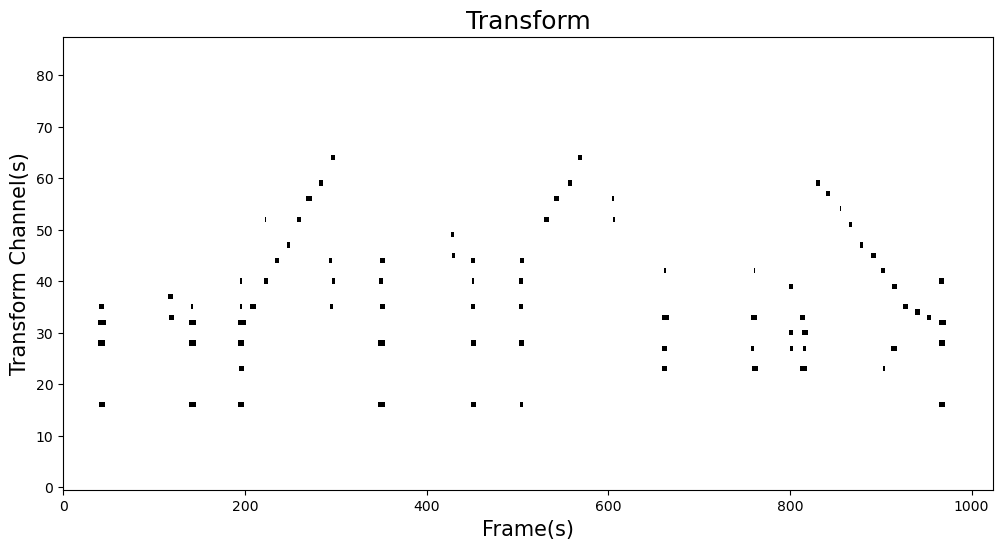

In [5]:
diagram = np.where(diagrams[0]>0.5, 1.0, 0.0)
util.plot_single_transform(diagram[0:1024, :], cmap='gray_r')

### Common Starting Model
___

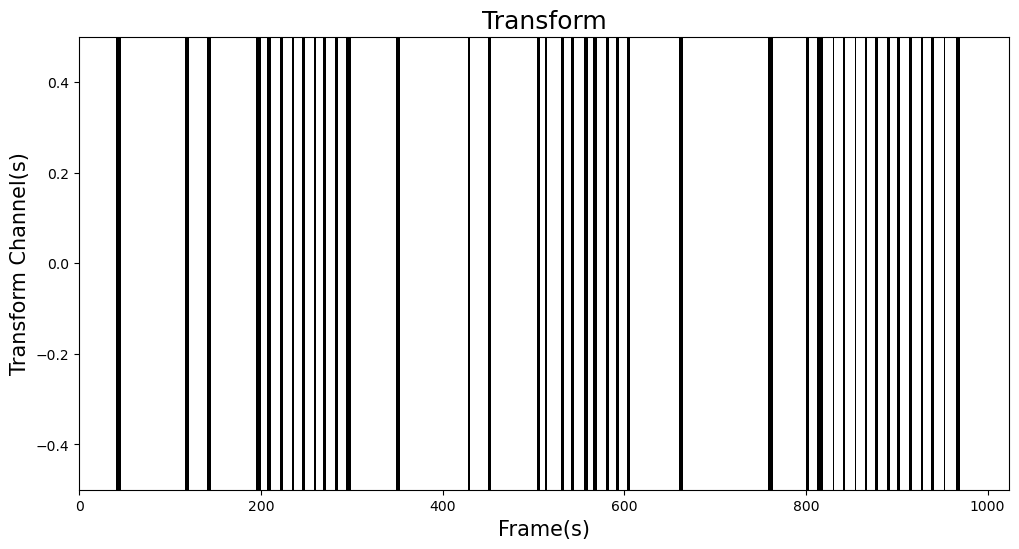

In [6]:
diagram = np.where(diagrams[1]>0.5, 1.0, 0.0)
util.plot_single_transform(diagram[0:1024, :], cmap='gray_r')


### Multi-tone Duration Model
___

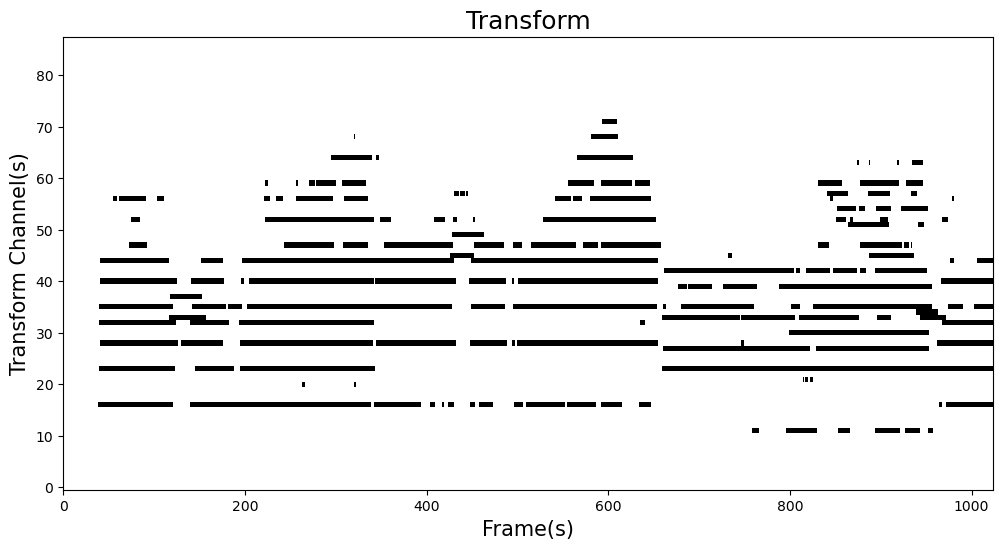

In [7]:
diagram = np.where(diagrams[2]>0.5, 1.0, 0.0)
util.plot_single_transform(diagram[0:1024, :], cmap='gray_r')

## 4.3) Predict Test

In [6]:
predict_test = model_cnn_inference.Transcription_Model(
    multitone_start_path = initial.config['detect.model.multistart.weight'],
    common_start_path = initial.config['detect.model.commonstart.weight'],
    multitone_duration_path = initial.config['detect.model.multiduration.weight'])
piano_roll, notes = predict_test.notes_plot('data\MAPS_MUS-bk_xmas1_ENSTDkAm.wav')

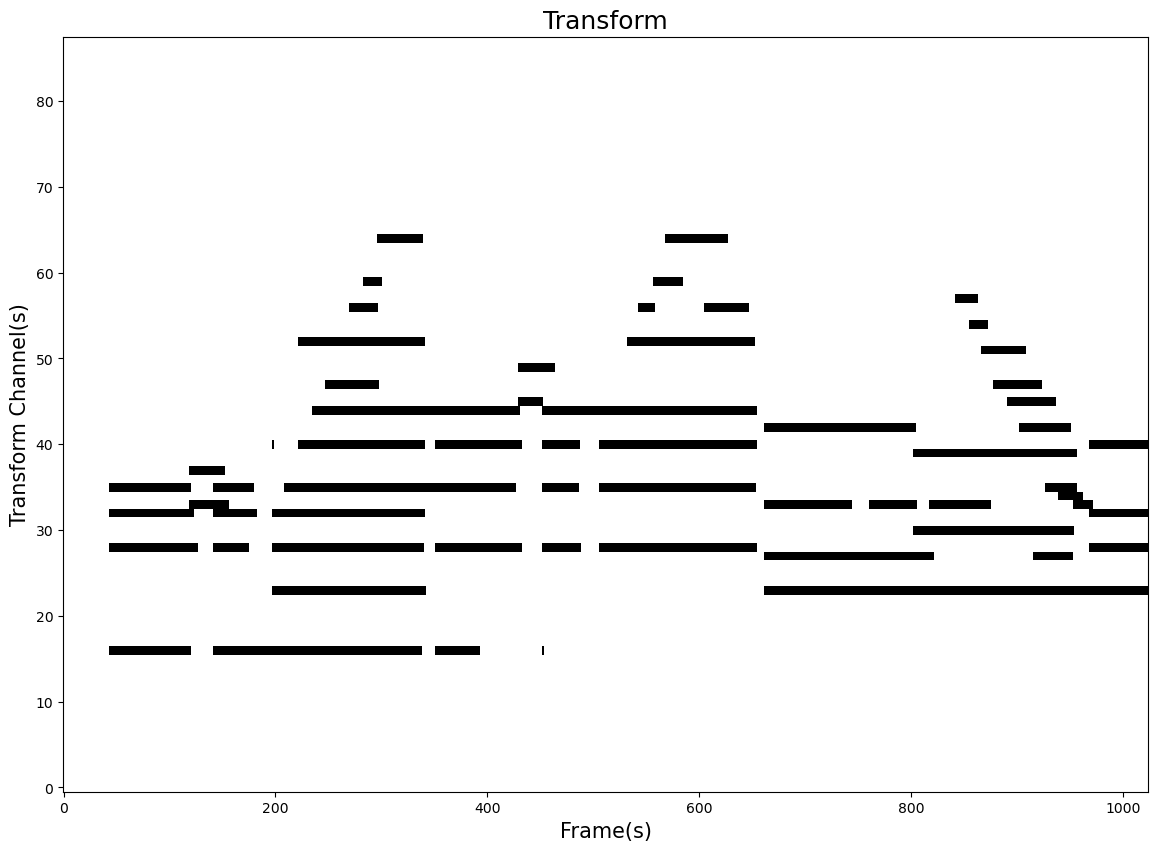

In [7]:
util.plot_single_transform(piano_roll[0:1024, :], cmap='gray_r')

## 4.4) mir_eval Test

In [6]:
all_pitch_eval_result = model_cnn_eval.eval_all_pitch(
    multitone_start_path = initial.config['detect.model.multistart.weight'],
    common_start_path = initial.config['detect.model.commonstart.weight'],
    multitone_duration_path = initial.config['detect.model.multiduration.weight']
)

evaluation percentage: 100.0 [60/60]


In [7]:
all_pitch_eval_result

,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
0,0.382213,0.303996,0.338647,0.778806,0.867617,0.690065,0.768722,0.571815,0.895451,0.712203,0.793383,0.691107,0.549676,0.612331
1,0.552319,0.510469,0.530570,0.908422,0.856526,0.791625,0.822798,0.772099,0.892125,0.824526,0.856995,0.732470,0.676969,0.703627
2,0.316578,0.218636,0.258646,0.867777,0.754850,0.521315,0.616715,0.642699,0.805996,0.556638,0.658501,0.618166,0.426918,0.505043
3,0.622416,0.597701,0.609808,0.892838,0.907145,0.871125,0.888770,0.789887,0.920203,0.883664,0.901564,0.767864,0.737374,0.752310
4,0.413598,0.356387,0.382867,0.851020,0.769594,0.663141,0.712413,0.651351,0.830973,0.716029,0.769231,0.725212,0.624898,0.671329
5,0.509688,0.406040,0.451999,0.901623,0.855939,0.681879,0.759059,0.734414,0.882056,0.702685,0.782219,0.770008,0.613423,0.682854
6,0.387525,0.214402,0.276067,0.759022,0.841847,0.465761,0.599720,0.560284,0.911100,0.504076,0.649055,0.720530,0.398641,0.513296
7,0.409006,0.257683,0.316171,0.836731,0.846154,0.533097,0.654097,0.642206,0.949343,0.598109,0.733865,0.723265,0.455674,0.559101
8,0.500000,0.415563,0.453888,0.861849,0.657371,0.546358,0.596745,0.759652,0.695219,0.577815,0.631103,0.898406,0.746689,0.815552
9,0.466345,0.309761,0.372257,0.842426,0.902387,0.599394,0.720325,0.654000,0.957629,0.636088,0.764423,0.735318,0.488422,0.586963


In [ ]:
each_pitch_eval_result = model_cnn_eval.eval_each_pitch(
    multitone_start_path = initial.config['detect.model.multistart.weight'],
    common_start_path = initial.config['detect.model.commonstart.weight'],
    multitone_duration_path = initial.config['detect.model.multiduration.weight']
)

In [ ]:
each_pitch_eval_result

In [4]:
est_pitch_eval_result = model_cnn_eval.est_each_pitch()

In [5]:
est_pitch_eval_result

,count
0,2.0
1,0.0
2,1.0
3,9.0
4,24.0
...,...
83,6.0
84,3.0
85,0.0
86,0.0
